In [1]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from yellowbrick.cluster import KElbow
from mlxtend.frequent_patterns import fpgrowth
import warnings
warnings.filterwarnings(action="ignore")
%load_ext autotime

In [75]:
class Binner():
    
    def __init__(self):
        self.models = {}
        self.number_of_bins_range = (2,10)
        self.minimal_support_rate = .25
        self.threshold = 1.0
        
    def sort_model_labels(self, model, original_labels):
        """Sorts labels in ascending order (cluster means) using a fit KMeans model
        After sorting, the higher the label number, the higher the average values of the data with that label
        Parameters
        ----------
        model : a fit KMeans model
        original_labels : the labels we want to sort 
        Returns
        -------
        the sorted labels
        """
        label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
        lookup_table = np.zeros_like(label_idx)
        lookup_table[label_idx] = np.arange(model.n_clusters)
        sorted_labels = lookup_table[original_labels]
        return sorted_labels
        
    def create_bins(self, column_name, df, number_of_bins_range=(2,10), replace_in_df=True, verbose=False):
        """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
        Parameters
        ----------
        column_name : the name of pandas dataframe column to convert
        df : pandas dataframe object
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        replace_in_df : boolean, optional
            Whether to replace the column in the dataframe with the binned values (default: True).
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        the binned values 
        """
        self.number_of_bins_range = number_of_bins_range
        data_to_bin = np.array(df[column_name]).reshape(-1, 1)
        model = KMeans(random_state=100, n_init=10, n_jobs=-1)
        elbow = KElbow(model, k=number_of_bins_range)
        elbow.fit(data_to_bin)
        optimal_number_of_bins = elbow.elbow_value_
        model.set_params(n_clusters=optimal_number_of_bins)
        model.fit(data_to_bin)
        model.labels_ = self.sort_model_labels(model, model.labels_)
        self.models[column_name] = model
        if replace_in_df:
            df[column_name] = model.labels_
        if verbose:
            print("For column: {}, optimal number of bins: {}".format(column_name, optimal_number_of_bins))
        return model.labels_
    
    
    def find_patterns(self, df, minimal_support_rate=.33, number_of_bins_range=(2,10), verbose=False):
        """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
        Parameters
        ----------
        df : pandas dataframe object
        minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        all patterns found above minimal support rate
        """
        self.models = {}
        self.minimal_support_rate = minimal_support_rate
        for column in df.columns:
            try:
                data_is_numeric = np.issubdtype(df[column].dtype, np.number)
            except Exception as e:
                print("Error creating bins for column: {}\n{}\n".format(column, e))
                data_is_numeric = False
            if data_is_numeric:
                try:
                    binned_values = self.create_bins(column, df, number_of_bins_range=number_of_bins_range, verbose=verbose)
                except Exception as e:
                    print("Error creating bins for column: {}\n{}\n".format(column, e))
        df = pd.get_dummies(df, columns=df.columns)
        self.patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
        return self.patterns
    
    def transform_dataset(self, df):
        """Transforms a dataset, converting all continuous features to discrete using the previously fit KMeans models for labels
        Parameters
        ----------
        df : pandas dataframe object to transform
        Returns
        -------
        the transformed dataset
        """
        for column in df.columns:
            if column in self.models:
                model = self.models[column]
                predicted_labels = model.predict(np.array(df[column]).reshape(-1,1))
                sorted_labels = self.sort_model_labels(model, predicted_labels)
                df[column] = sorted_labels
        df = pd.get_dummies(df, columns=df.columns)
        return df
    
    def get_pattern_support_rate(self, pattern, df, verbose=False):
        """Gets the support rate for a pattern for a new dataset
        Parameters
        ----------
        pattern : a pattern object
        df : pandas dataframe object
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        all patterns found above minimal support rate
        """
        pattern_columns = []
        for item in pattern['itemsets']:
            pattern_columns.append(item)
        total_len = len(df)
        support_num = len(pd.np.where(df[pattern_columns].eq(1).all(1))[0])
        support_rate = support_num/total_len
        if verbose:
            print("Pattern Items: {}".format(pattern['itemsets']))
            print("Original Pattern Support Rate: {}".format(pattern['support']))
            print("Dataset Pattern Support Rate: {}".format(support_rate))
        return support_rate

    def get_best_subset_patterns(self, full_df, subset_df, minimal_support_rate=.25, threshold=1.0, number_of_bins_range=(2,10), verbose=False):
        """Finds the patterns with the biggest difference between subset data support rate and full data support rate
        Parameters
        ----------
        full_df : pandas dataframe object, full dataset to use for comparison
        subset_df : pandas dataframe object, subset dataset to use for comparison
        minimal_support_rate : float, optional (default: .25)
            a float between 0 and 1 for minimum support of the itemsets returned
        threshold : float, optional (default: 1.0)
            the threshold to use for the conditon: support_rate(full data) * threshold < support_rate(subset)
        number_of_bins_range : tuple, optional (defualt: (2,10))
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range.
        verbose : boolean, optional
            Whether to print out info
        Returns
        -------
        a dataframe with all the patterns that exceed the threshold equation for subset vs full dataset support rate
        """
        self.threshold = threshold
        subset_patterns = self.find_patterns(subset_df, minimal_support_rate=minimal_support_rate, number_of_bins_range=number_of_bins_range, verbose=verbose)
        subset_key_patterns = []
        if verbose:
            print("All Susbet Patterns:")
        for idx,pattern in subset_patterns.iterrows():
            full_dataset_support_rate = self.get_pattern_support_rate(pattern, self.transform_dataset(full_df.copy()))
            subset_support_rate = pattern['support']
            if full_dataset_support_rate * threshold < subset_support_rate:
                pattern_list = [item for item in pattern['itemsets']]
                subset_key_patterns.append({"pattern": pattern_list, "subset_support": subset_support_rate, "full_dataset_support": full_dataset_support_rate})
                if verbose:
                    print(pattern['itemsets'])
                
        subset_key_patterns = sorted(subset_key_patterns, key=lambda x: x['subset_support'] / x['full_dataset_support'], reverse=True)
        return pd.DataFrame(subset_key_patterns)

time: 12.8 ms


In [76]:
import seaborn as sns
iris = sns.load_dataset('iris')
titanic = sns.load_dataset('titanic')
binner = Binner()

time: 16.2 ms


Error creating bins for column: survived
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

Error creating bins for column: pclass
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

Error creating bins for column: age
Input contains NaN, infinity or a value too large for dtype('float64').

Error creating bins for column: sibsp
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.

Error creating bins for column: class
data type not understood

Error creating bins for column: deck
data type not understood



,pattern,subset_support,full_dataset_support
0,"[sibsp_1, pclass_1]",0.303419,0.079686
1,"[class_First, sibsp_1]",0.303419,0.079686
2,"[alone_False, sibsp_1, pclass_1]",0.303419,0.079686
3,"[alone_False, class_First, sibsp_1]",0.303419,0.079686
4,"[sibsp_1, class_First, pclass_1]",0.303419,0.079686
5,"[alone_False, sibsp_1, class_First, pclass_1]",0.303419,0.079686


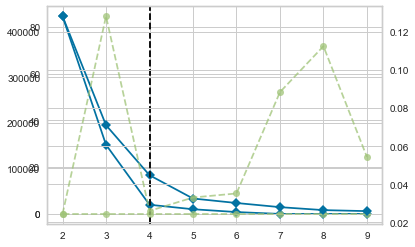

time: 10.6 s


In [77]:
subset_key_patterns = binner.get_best_subset_patterns(full_df=titanic, subset_df=titanic[titanic['fare'] > 30], 
                                                      minimal_support_rate=.3, threshold=3.8, number_of_bins_range=(2,10))
subset_key_patterns

For column: sepal_length, optimal number of bins: 4
For column: sepal_width, optimal number of bins: 4
For column: petal_length, optimal number of bins: 4
For column: petal_width, optimal number of bins: 3
All Susbet Patterns:
frozenset({'sepal_length_1'})
frozenset({'petal_width_1'})
frozenset({'species_versicolor'})
frozenset({'petal_length_2'})
frozenset({'sepal_length_2'})
frozenset({'petal_width_2'})
frozenset({'species_virginica'})
frozenset({'petal_width_1', 'species_versicolor'})
frozenset({'species_virginica', 'petal_width_2'})


,pattern,subset_support,full_dataset_support
0,"[species_virginica, petal_width_2]",0.330935,0.306667
1,[sepal_length_1],0.309353,0.286667
2,[petal_width_1],0.374101,0.346667
3,[species_versicolor],0.359712,0.333333
4,[petal_length_2],0.323741,0.300000
5,[sepal_length_2],0.345324,0.320000
6,[petal_width_2],0.345324,0.320000
7,[species_virginica],0.359712,0.333333
8,"[petal_width_1, species_versicolor]",0.345324,0.320000


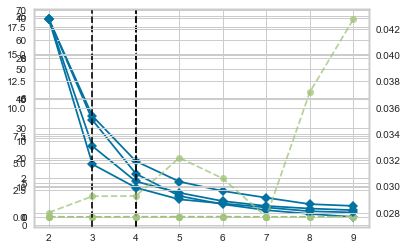

time: 2.19 s


In [78]:
subset_key_patterns = binner.get_best_subset_patterns(full_df=iris, subset_df=iris[iris['sepal_length'] > 4.7], 
                                                      minimal_support_rate=.25, threshold=1.07, number_of_bins_range=(2,10), verbose=True)
subset_key_patterns

Error creating bins for column: petal_width
Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by check_pairwise_arrays.



,pattern,subset_support,full_dataset_support
0,[species_setosa],1.00,0.333333
1,[petal_width_0.2],0.58,0.193333
2,[petal_length_1],0.40,0.133333
3,[petal_length_2],0.26,0.086667
4,"[species_setosa, petal_width_0.2]",0.58,0.193333
5,"[petal_length_1, species_setosa]",0.40,0.133333
6,"[sepal_width_2, species_setosa]",0.40,0.133333
7,"[species_setosa, sepal_length_2]",0.38,0.126667
8,"[species_setosa, sepal_width_1]",0.32,0.106667
9,"[petal_length_2, species_setosa]",0.26,0.086667


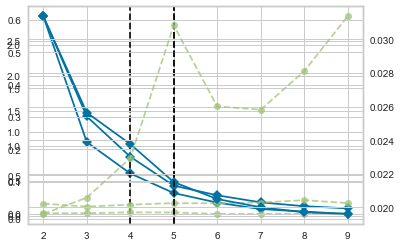

time: 1.74 s


In [80]:
subset_key_patterns = binner.get_best_subset_patterns(full_df=iris, subset_df=iris[iris['species'] == 'setosa'], 
                                                      minimal_support_rate=.25, threshold=1.45, number_of_bins_range=(2,10))
subset_key_patterns

In [12]:
class Binner():
    
    def __init__(self, df):
        self.df = df
        self.models = {}
        
    def sort_model_labels(self, model, original_labels):
        label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
        lookup_table = np.zeros_like(label_idx)
        lookup_table[label_idx] = np.arange(model.n_clusters)
        sorted_labels = lookup_table[original_labels]
        return sorted_labels
        
    def create_bins(self, column_name, df=None, number_of_bins_range=(2,10), replace_in_df=True):
        """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
        Parameters
        ----------
        column_name : the name of pandas dataframe column to convert
        df : pandas dataframe object, optional (default: self.df)
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        replace_in_df : boolean, optional
            Whether to replace the column in the dataframe with the binned values (default: True).
        Returns
        -------
        the binned values 
        """
        if df is None:
            df = self.df
        data_to_bin = np.array(df[column_name]).reshape(-1, 1)
        model = KMeans(random_state=100, n_init=10, n_jobs=-1)
        elbow = KElbow(model, k=number_of_bins_range)
        elbow.fit(data_to_bin)
        optimal_number_of_bins = elbow.elbow_value_
        model.set_params(n_clusters=optimal_number_of_bins)
        model.fit(data_to_bin)
#         label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
#         lookup_table = np.zeros_like(label_idx)
#         lookup_table[label_idx] = np.arange(optimal_number_of_bins)
#         model.labels_ = lookup_table[model.labels_]
        model.labels_ = self.sort_model_labels(model, model.labels_)
        self.models[column_name] = model
        if replace_in_df:
            df[column_name] = model.labels_
        return model.labels_
    
    
    def find_patterns(self, df=None, minimal_support_rate=.33, number_of_bins_range=(2,10)):
        """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
        Parameters
        ----------
        df : pandas dataframe object, optional (default: self.df)
        minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
        number_of_bins_range : tuple, optional
            The range of values for number of bins to try, the algorithm will automatically 
            select the best one from the range (default: (2,10)).
        Returns
        -------
        all patterns found above minimal support rate
        """
        if df is None:
            df = self.df
        for column in df.columns:
            if np.issubdtype(df[column].dtype, np.number):
                try:
                    binned_values = self.create_bins(column, df=df, number_of_bins_range=number_of_bins_range)
                except:
                    pass
        df = pd.get_dummies(df, columns=df.columns)
        self.patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
        return self.patterns
    
    def transform_dataset(self, df):
        for column in df.columns:
            if column in self.models:
                model = self.models[column]
#                 label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
#                 lookup_table = np.zeros_like(label_idx)
#                 lookup_table[label_idx] = np.arange(model.n_clusters)
                predicted_labels = model.predict(np.array(df[column]).reshape(-1,1))
#                 sorted_labels = lookup_table[predicted_labels]
                sorted_labels = self.sort_model_labels(model, predicted_labels)
                
                df[column] = sorted_labels
        df = pd.get_dummies(df, columns=df.columns)
        return df
    
    def iris['species'](self, pattern, df, verbose=False):
        pattern_columns = []
        for item in pattern['itemsets']:
            pattern_columns.append(item)
        total_len = len(df)
        support_num = len(pd.np.where(df[pattern_columns].eq(1).all(1))[0])
        support_rate = support_num/total_len
        if verbose:
            print("Pattern Items: {}".format(pattern['itemsets']))
            print("Original Pattern Support Rate: {}".format(pattern['support']))
            print("Dataset Pattern Support Rate: {}".format(support_rate))
        return support_rate

    def get_best_subset_patterns(self, full_df, subset_patterns, threshold=1, verbose=False):
        subset_key_patterns = []
        for idx,pattern in subset_patterns.iterrows():
            full_dataset_support_rate = self.get_pattern_support_rate(pattern, self.transform_dataset(full_df.copy()))
            subset_support_rate = pattern['support']
            if full_dataset_support_rate * threshold < subset_support_rate:
                pattern_list = [item for item in pattern['itemsets']]
                subset_key_patterns.append(pattern_list)
                if verbose:
                    print(pattern['itemsets'])
                
        return subset_key_patterns

time: 8.79 ms


In [58]:
threshold = 1.45
subset_key_patterns = []
for idx,pattern in patterns.iterrows():
    full_dataset_support_rate = bins.get_pattern_support_rate(pattern, bins.transform_dataset(iris.copy()))
    subset_support_rate = pattern['support']
    if full_dataset_support_rate * threshold < subset_support_rate:
        print(pattern['itemsets'])
        subset_key_patterns.append(pattern['itemsets'])

frozenset({'species_versicolor'})
frozenset({'petal_length_1'})
frozenset({'petal_width_1'})
frozenset({'sepal_length_1'})
frozenset({'sepal_width_1'})
frozenset({'petal_width_2'})
frozenset({'species_virginica'})
frozenset({'petal_length_2'})
frozenset({'species_versicolor', 'petal_length_1'})
frozenset({'species_versicolor', 'petal_width_1'})
frozenset({'sepal_length_0', 'species_versicolor'})
frozenset({'species_versicolor', 'petal_length_0'})
frozenset({'petal_length_2', 'species_virginica'})
time: 270 ms


In [9]:
.1666 * .5 < .25

True

time: 4.14 ms


In [2]:
def create_bins(df, column_name, number_of_bins_range=(2,10), replace_in_df=True):
    """An adaptive binning algorithm to convert a continuous pandas dataframe column to discrete. K means algorithm is used to create bins. Mean sum of squared distances to center is used for evaluation. Knee point detection algorithm is used to select the best number of bins.
    Parameters
    ----------
    df : pandas dataframe object
    column_name : the name of pandas dataframe column to convert
    number_of_bins_range : tuple, optional
        The range of values for number of bins to try, the algorithm will automatically 
        select the best one from the range (default: (2,10)).
    replace_in_df : boolean, optional
        Whether to replace the column in the dataframe with the binned values (default: True).
    Returns
    -------
    the binned values 
    """
    data_to_bin = np.array(df[column_name]).reshape(-1, 1)
    model = KMeans(random_state=100, n_init=10, n_jobs=-1)
    visualizer = KElbowVisualizer(model, k=number_of_bins_range).fit(data_to_bin)
    optimal_number_of_bins = visualizer.elbow_value_
    model.set_params(n_clusters=optimal_number_of_bins)
    model.fit(data_to_bin)
    label_idx = np.argsort(model.cluster_centers_.sum(axis=1))
    lookup_table = np.zeros_like(label_idx)
    lookup_table[label_idx] = np.arange(optimal_number_of_bins)
    bins = lookup_table[model.labels_]
    if replace_in_df:
        df[column_name] = binned_values
    return binned_values

time: 8.81 ms


In [3]:
def find_patterns(df, minimal_support_rate=.33, number_of_bins_range=(2,10)):
    """FP-growth algorithm to find patterns in the dataframe with a minimal support rate, after converting continuous features to discrete
    Parameters
    ----------
    df : pandas dataframe object
    minimal_support_rate : a float between 0 and 1 for minimum support of the itemsets returned
    number_of_bins_range : tuple, optional
        The range of values for number of bins to try, the algorithm will automatically 
        select the best one from the range (default: (2,10)).
    Returns
    -------
    all patterns found above minimal support rate
    """
    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            try:
                binned_values = create_bins(df, column, number_of_bins_range=number_of_bins_range)
            except e:
                pass
    df = pd.get_dummies(df, columns=df.columns)
    patterns = fpgrowth(df, min_support=minimal_support_rate, use_colnames=True)
    return patterns

time: 2.41 ms


,support,itemsets
0,0.333333,(species_setosa)
1,0.333333,(petal_width_0)
2,0.333333,(petal_length_0)
3,0.406667,(sepal_width_1)
4,0.346667,(petal_width_1)
5,0.333333,(species_versicolor)
6,0.333333,(species_virginica)
7,0.333333,"(petal_width_0, species_setosa)"
8,0.333333,"(petal_length_0, petal_width_0)"
9,0.333333,"(petal_length_0, species_setosa)"


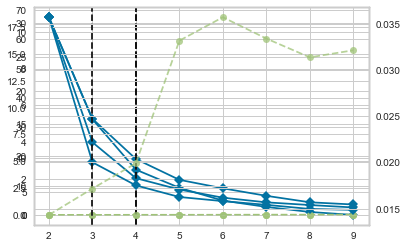

time: 2.43 s


In [4]:
import seaborn as sns
iris = sns.load_dataset('iris')
patterns = find_patterns(iris)
patterns